# Direct Bank Marketing Campaigns: Comparing Classifiers

### Overview 

In this practical application, the goal is to compare the performance of the classifiers namely **K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines**.  The dataset is related to marketing bank products over the telephone. The objective is to build a predictive model that could predict if a bank's customer would likely subscribe to long term deposit product or not. It's going to be a binary classification model with target class label of 'yes' or 'no'.



### Business Objective

In the competetive world of banking, there's always pressure on the banks to increase the financial assets. One of the approaches to achieve this is by running the direct marketing campaigns on their existing customers by offering the long-term deposit products with attactive interest rates. Business would like to get a tool that could predict if a given customer would likely subscribe to long-term deposit product or not.

### Data Set Description

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Step 1: Read the Data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call, check_call

In [2]:
# Read the dataset from CSV file
bank = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
# Display top rows
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Check the shape of the dataset (row x columns)
bank.shape

(41188, 21)

In [5]:
# Display the statistical info of the dataset
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
# Check the value count of subscribed contacts
bank['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [7]:
# Check the value count of marital values
bank['marital'].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [8]:
# Check the value count of job values
bank['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [9]:
# Check the value count of education values
bank['education'].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [10]:
# Check the value count of housing values
bank['housing'].value_counts()

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

In [11]:
# Check the value count of default values
bank['default'].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [12]:
# Check the value count of loan values
bank['loan'].value_counts()

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

### Step 2: Understanding the Data

After examining the dataset above, following observations can be made:
- There are total 41188 datapoints (rows) and 21 features (columns).
- There is no missing data.
- There are 8 Categorical, 1 Binary, 2 Date and 10 Numerical features.
- Target class is imbalanced i.e. 4640 subscribed out of 41188 (~11% success rate of getting the customers to subscribe to term deposit products)

### Step 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



**Observations**
- Feature 'y' can be renamed as 'subscribed' to give a better name.
- Categorical data needs to be convereted to numeric during data preparation and exploration step.

### Step 4: Engineering Features

Now that we understand the business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

#### 4.1 Exploratory Analysis

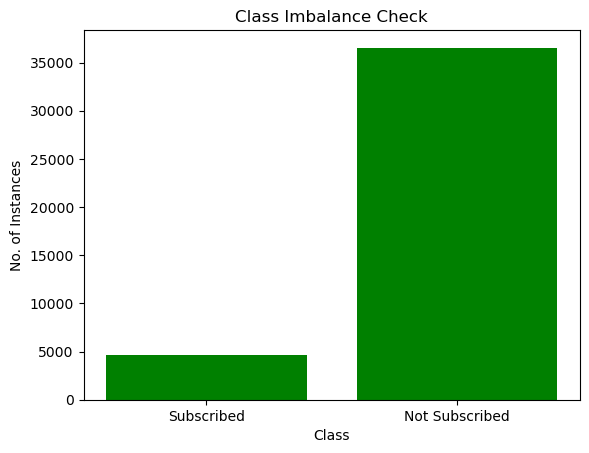

In [13]:
# Visualize the target feature distribution
subscribed = list(bank['y'])
count_per_class = {'yes' : subscribed.count('yes'), 'no' : subscribed.count('no')}

plt.bar([0, 1], count_per_class.values(), color='green')
plt.xlabel('Class')
plt.ylabel('No. of Instances')
plt.title('Class Imbalance Check')
plt.xticks([0, 1], ['Subscribed', 'Not Subscribed'])
plt.show()

**Normalized relative frequency of the target class**

In [14]:
# Define categorical features list
category_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'y']

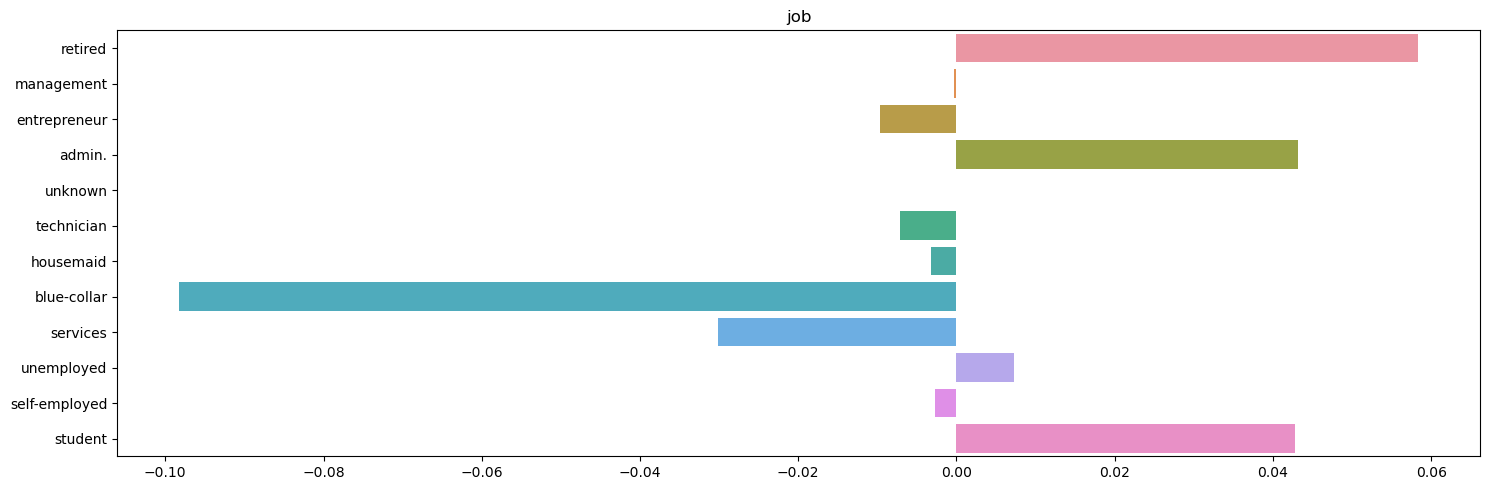

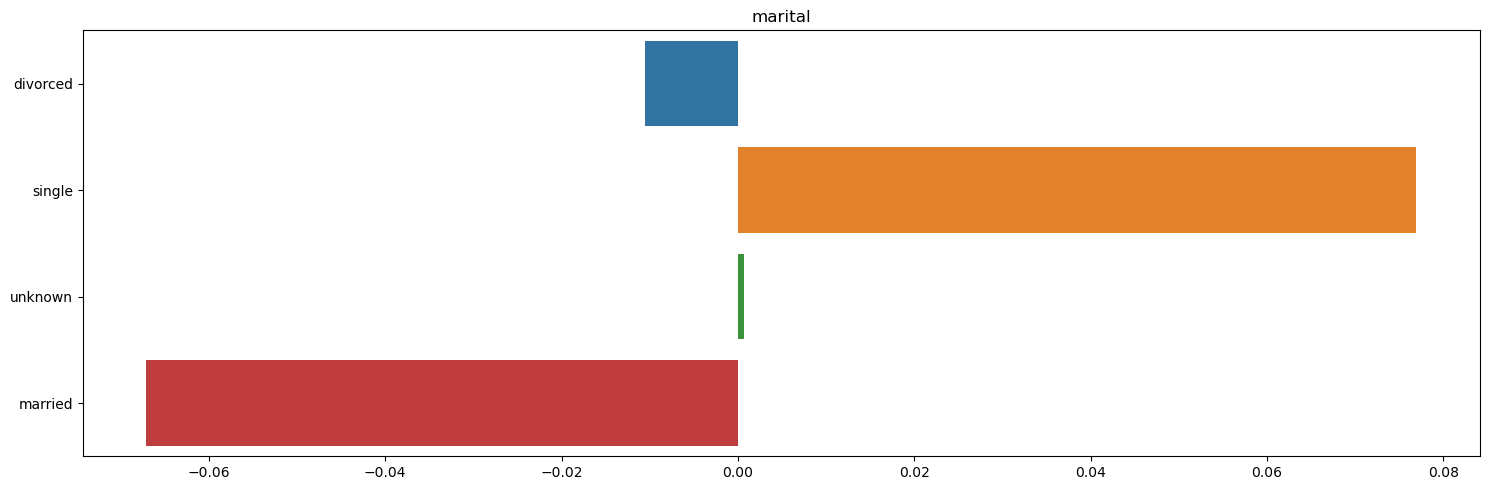

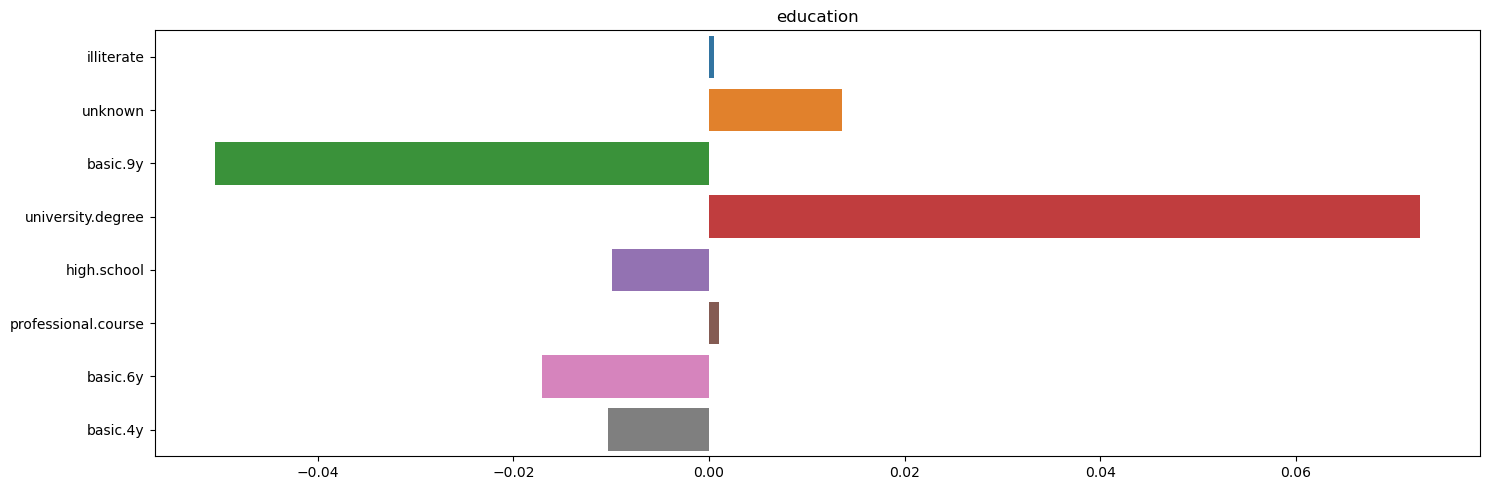

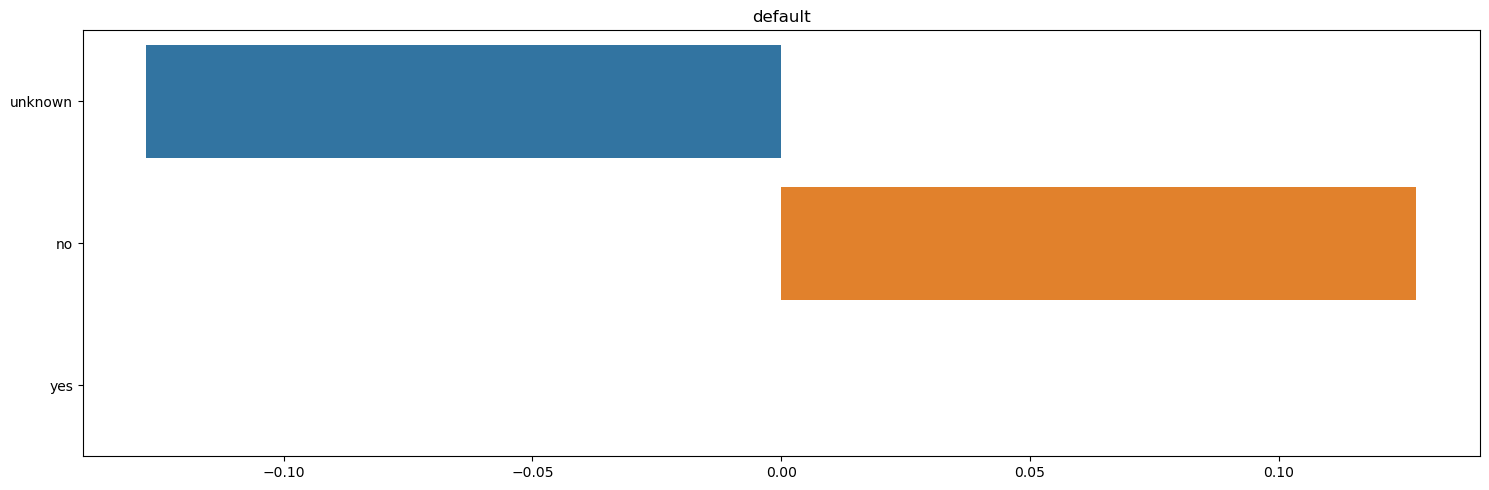

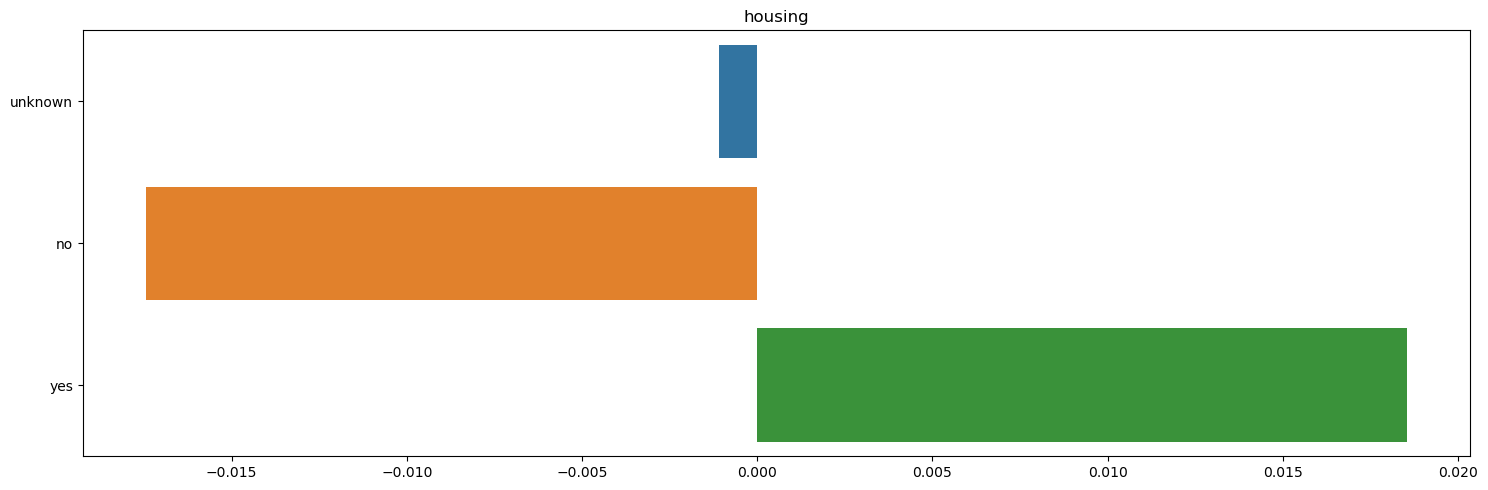

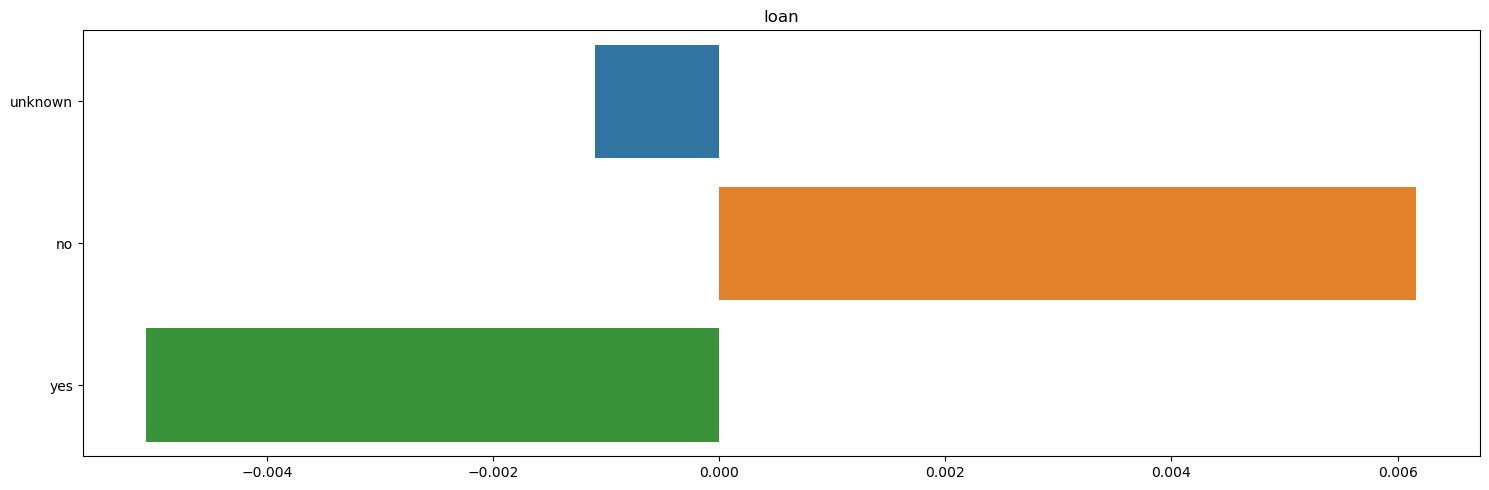

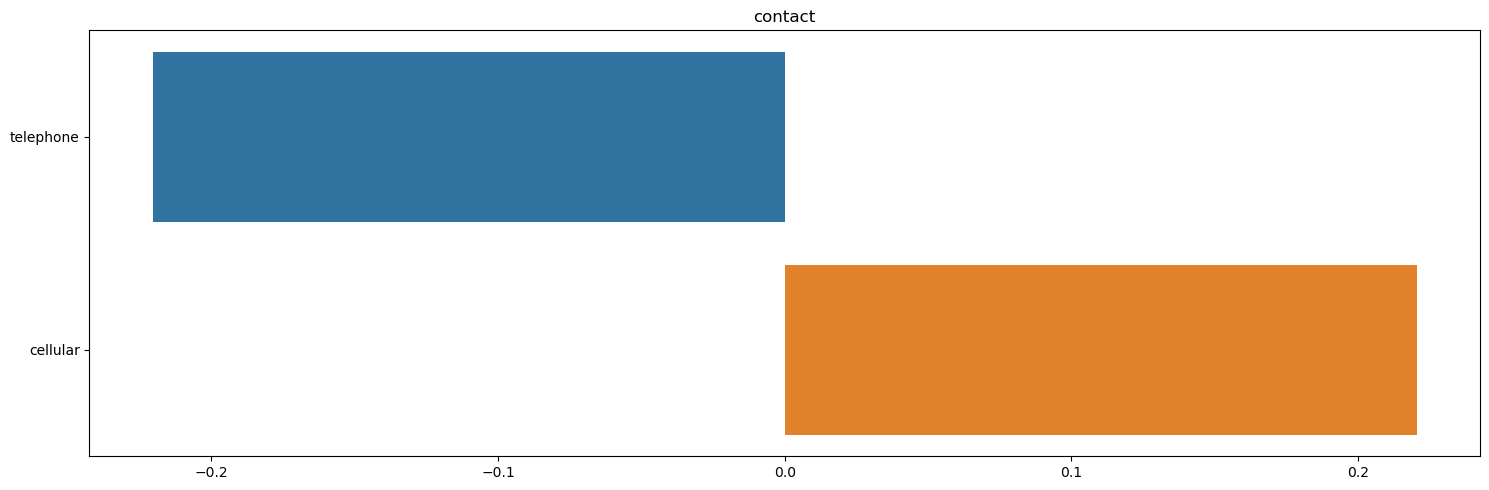

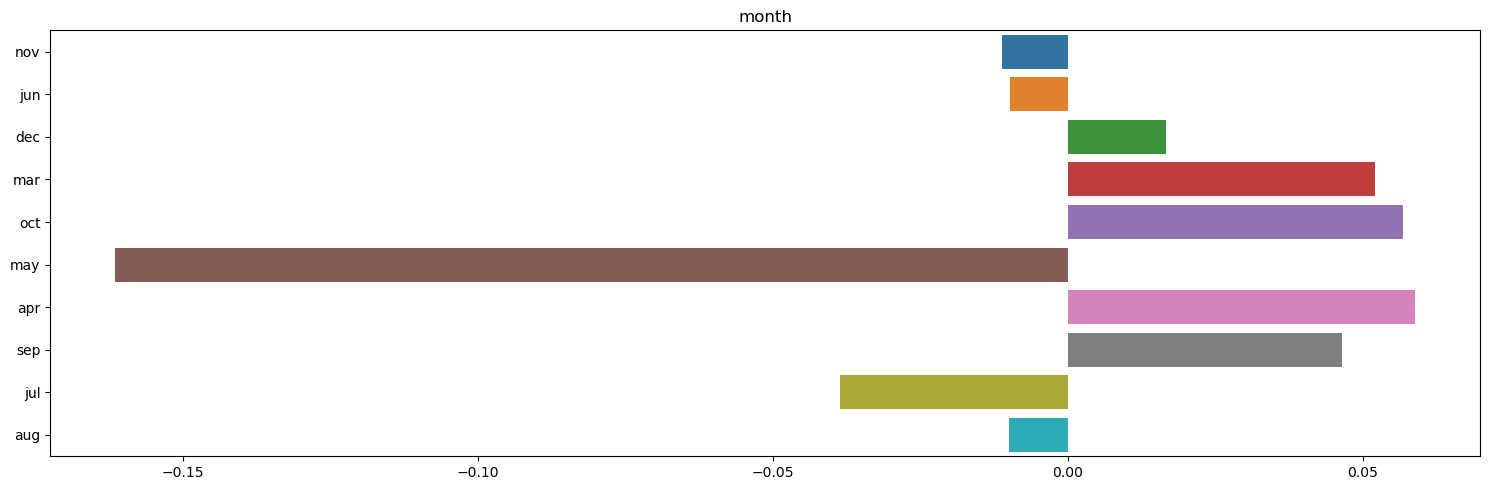

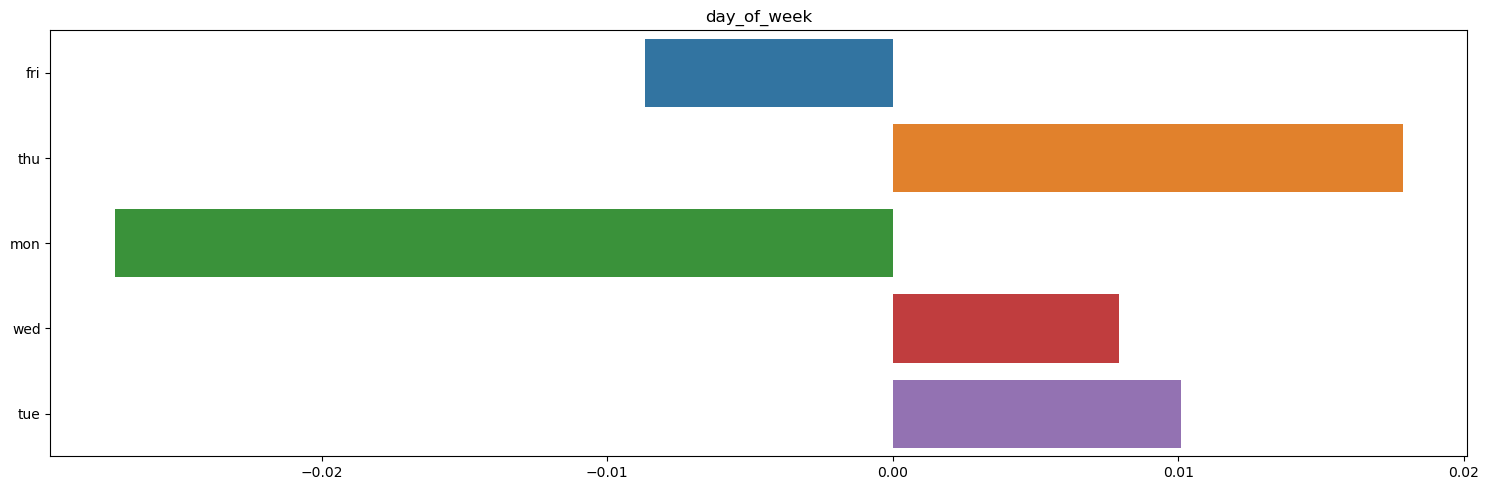

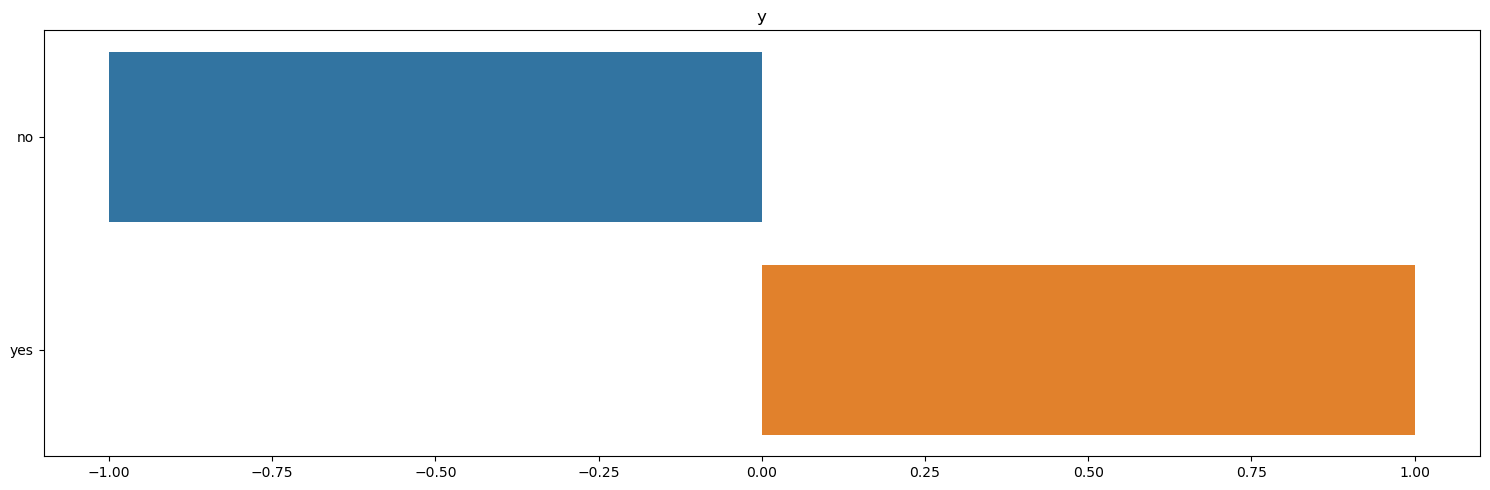

In [15]:
# Visualize normalized relative frequency of the target class
for feature in category_features:
    plt.figure(figsize=(15,5))
    # Returns the unique value count for each feature per target class
    positive_cnt = bank.loc[bank.y.values == 'yes', feature].value_counts() 
    negative_cnt = bank.loc[bank.y.values == 'no', feature].value_counts()
    
    total_cnt = list(set(list(positive_cnt.index) + list(negative_cnt.index)))
    
    # Unique value count of target class
    total_positive_cnt = (bank.y.values == 'yes').sum()
    total_negative_cnt = (bank.y.values == 'no').sum()
    
    positive_cnt = positive_cnt.to_dict()
    negative_cnt = negative_cnt.to_dict()
    
    all_indexes = list(total_cnt)
    total_cnt = [positive_cnt.get(j, 0) / total_positive_cnt - negative_cnt.get(j, 0) / total_negative_cnt for j in total_cnt]

    sns.barplot(x = total_cnt, y = all_indexes)
    plt.title(feature)
    plt.tight_layout()

**Observations**
- There are 'unknown' values in the dataset that can be considered equivalent to missing data.
- Features with 'unknown' values are : 'education', 'job', 'housing', 'loan', 'deafult', and 'marital'. The count of 'unknown' in 'marital' feature is very low (total 80) but other features like 'education', 'job', 'housing', and 'loan' have significant enough to warrant filling them with proper data using imputation technique.
- We can make use of the cross-tabulation between two features to infer the value for one based on the other. For example - 'job' and 'education', 'age' and 'job' etc.

In [16]:
# function to perform cross-tabulation between given features
def cross_tabulation(df,feature1,feature2):
    list_feature2=list(df[feature2].unique())
    dataframes=[]
    for value2 in list_feature2:
        df2=df[df[feature2]==value2]
        df1=df2.groupby(feature1).count()[feature2]
        dataframes.append(df1)
    x1=pd.concat(dataframes,axis=1)
    x1.columns=list_feature2
    x1=x1.fillna(0)
    return x1

In [17]:
# function to replace the 'unknown' value of feature1 based on cross-tabulation inference with feature2 value
def replace_unknown(df, feature1, value1, feature2, value2):
    df.loc[(df[feature1]=='unknown') & (df[feature2]==value2), feature1] = value1

In [18]:
# Check the count of jobs for customer's age > 60 years
bank['job'][bank['age']>60].value_counts()

retired          678
housemaid         54
admin.            47
technician        34
management        30
unknown           21
blue-collar       20
self-employed      9
entrepreneur       8
unemployed         7
services           2
Name: job, dtype: int64

In [19]:
# Most of the customers with age > 60 are retired so we can fill the 'unknown' 'job' for 'age' > 60 with retired value.
bank.loc[(bank['age']>60) & (bank['job']=='unknown'), 'job'] = 'retired'

In [20]:
cross_tabulation(bank,'job','education')

,basic.4y,high.school,basic.6y,basic.9y,professional.course,unknown,university.degree,illiterate
job,,,,,,,,
admin.,77,3329,151,499,363,249,5753,1.0
blue-collar,2318,878,1426,3623,453,454,94,8.0
entrepreneur,137,234,71,210,135,57,610,2.0
housemaid,474,174,77,94,59,42,139,1.0
management,100,298,85,166,89,123,2063,0.0
retired,601,276,75,145,243,112,286,3.0
self-employed,93,118,25,220,168,29,765,3.0
services,132,2682,226,388,218,150,173,0.0
student,26,357,13,99,43,167,170,0.0


In [21]:
cross_tabulation(bank,'education','job')

,housemaid,services,admin.,blue-collar,technician,retired,management,unemployed,self-employed,unknown,entrepreneur,student
education,,,,,,,,,,,,
basic.4y,474,132.0,77,2318,58.0,601,100.0,112.0,93,48.0,137,26.0
basic.6y,77,226.0,151,1426,87.0,75,85.0,34.0,25,22.0,71,13.0
basic.9y,94,388.0,499,3623,384.0,145,166.0,186.0,220,31.0,210,99.0
high.school,174,2682.0,3329,878,873.0,276,298.0,259.0,118,37.0,234,357.0
illiterate,1,0.0,1,8,0.0,3,0.0,0.0,3,0.0,2,0.0
professional.course,59,218.0,363,453,3320.0,243,89.0,142.0,168,10.0,135,43.0
university.degree,139,173.0,5753,94,1809.0,286,2063.0,262.0,765,44.0,610,170.0
unknown,42,150.0,249,454,212.0,112,123.0,19.0,29,117.0,57,167.0


In [22]:
# Based on the above cross-tabulation results, we can fill the 'job' and 'education' values appropriately
replace_unknown(bank, 'education', 'university.degree', 'job', 'admin.')
replace_unknown(bank, 'education', 'basic.9y', 'job', 'blue-collar')
replace_unknown(bank, 'education', 'university.degree', 'job', 'entrepreneur')
replace_unknown(bank, 'education', 'basic.4y', 'job', 'housemaid')
replace_unknown(bank, 'education', 'university.degree', 'job', 'management')
replace_unknown(bank, 'education', 'university.degree', 'job', 'self-employed')
replace_unknown(bank, 'education', 'high.school', 'job', 'services')
replace_unknown(bank, 'education', 'professional.course', 'job', 'technician')

replace_unknown(bank, 'job', 'blue-collar', 'education', 'basic.4y')
replace_unknown(bank, 'job', 'blue-collar', 'education', 'basic.6y')
replace_unknown(bank, 'job', 'blue-collar', 'education', 'basic.9y')
replace_unknown(bank, 'job', 'admin.', 'education', 'high.school')
replace_unknown(bank, 'job', 'technician', 'education', 'professional.course')
replace_unknown(bank, 'job', 'admin.', 'education', 'university.degree')

In [23]:
# Let's check the dataset after replacing the 'unknown' values
cross_tabulation(bank,'job','education')

,basic.4y,high.school,basic.6y,basic.9y,professional.course,university.degree,unknown,illiterate
job,,,,,,,,
admin.,77.0,3366.0,151.0,499.0,363.0,6046.0,0.0,1.0
blue-collar,2366.0,878.0,1448.0,4108.0,453.0,94.0,0.0,8.0
entrepreneur,137.0,234.0,71.0,210.0,135.0,667.0,0.0,2.0
housemaid,516.0,174.0,77.0,94.0,59.0,139.0,0.0,1.0
management,100.0,298.0,85.0,166.0,89.0,2186.0,0.0,0.0
retired,601.0,276.0,75.0,145.0,243.0,286.0,112.0,3.0
self-employed,93.0,118.0,25.0,220.0,168.0,794.0,0.0,3.0
services,132.0,2832.0,226.0,388.0,218.0,173.0,0.0,0.0
student,26.0,357.0,13.0,99.0,43.0,170.0,167.0,0.0


**Handling Categorical Features in Ordinal Category**

Convert and assign ordinal values to 'poutcome', 'default', 'housing', 'loan'

In [24]:
# Handling Ordinal features
bank['poutcome'] = bank['poutcome'].map({'failure': -1,'nonexistent': 0,'success': 1})
bank['default'] = bank['default'].map({'yes': -1,'unknown': 0,'no': 1})
bank['housing'] = bank['housing'].map({'yes': -1,'unknown': 0,'no': 1})
bank['loan'] = bank['loan'].map({'yes': -1,'unknown': 0,'no': 1})

In [25]:
# Let see the summary of our numerical features
numerical_features = ['age', 'default', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'poutcome',
                      'emp.var.rate', 'cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
bank[numerical_features].describe()

,age,default,housing,loan,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,0.791128,-0.071720,0.672575,2.567593,962.475454,0.172963,-0.069899,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,0.406686,0.985314,0.723616,2.770014,186.910907,0.494901,0.362886,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,-1.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000,-1.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,-1.000000,1.000000,1.000000,999.000000,0.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,1.000000,-1.000000,1.000000,2.000000,999.000000,0.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,1.000000,1.000000,1.000000,3.000000,999.000000,0.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,1.000000,1.000000,1.000000,56.000000,999.000000,7.000000,1.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### 4.2 Outliers

Outliers are defined as 1.5 x 75th percentile. From the above statistics, we can see that only 'age' and 'campaign' features have outliers. But the values of these outliers are also not so unrealistic i.e max 'age' = 98 and max 'campaign' = 56. Therefore, there is no need remove them and this improves the generalizability of the model and makes it closer to real world scenarios.

In [26]:
# Rename 'y' to 'subscribed' to give a meaningful name
bank.rename(columns = {'y':'subscribed'}, inplace = True) 
# Convert subscribed yes/no to 1/0
bank['subscribed'] = bank['subscribed'].map({'yes': 1, 'no': 0})

In [27]:
# Create X, y dataframes
X = bank.drop(['subscribed'], axis = 1)
y = bank['subscribed']

### Step 5: Train/Test Split

With our data prepared, let's split it into a train and test set. Since the dataset is highly imbalanced, we will use the stratification (keeping the target distribution unchanged). A random train/test split could probably change the target distribution quite a bit.

In [28]:
# Split the data as training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

In [29]:
# Print the Original distribution and after Split
print('Original:', (bank.subscribed).mean(), 'Train:', y_train.mean(), 'Test:', y_test.mean())

Original: 0.11265417111780131 Train: 0.11265417111780131 Test: 0.11265417111780131


In [30]:
cat_features_list = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week']

In [31]:
# Create Transformer object
transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), cat_features_list),
                                      remainder = StandardScaler())

### Step 6: A Baseline Model

Before we build our first model, we want to establish a baseline for the Logistic Regression algorithms.

In [32]:
# Create a dataframe to track the base model results
base_results_df = pd.DataFrame(index=['Train Accuracy (%)', 'Test Accuracy (%)', 'Train Time'])

In [33]:
# Define a function to store the base results
def save_base_results(modelName, model):
    results_data = []
    start_time = time.time()
    model.fit(X_train, y_train)
    stop_time = time.time()
    print(f"Results for Base {modelName}:")
    print(f"    Training Time    : {stop_time - start_time}s")
    base_trn_acc = model.score(X_train, y_train)
    base_tst_acc = model.score(X_test, y_test)
    print(f"    Training Accuracy: {base_trn_acc}")
    print(f"    Test Accuracy    : {base_tst_acc}")
    
    results_data.append(base_trn_acc*100)
    results_data.append(base_tst_acc*100)
    results_data.append(stop_time - start_time)
    return results_data

In [34]:
# Build base LogisticRegression model
lgr_base_pipe = Pipeline([('transformer', transformer), ('lgr', LogisticRegression(max_iter=1000))])

# Store the results
model_name = 'Logistic Regression'
base_results_df[model_name] = save_base_results(model_name, lgr_base_pipe)

Results for Base Logistic Regression:
    Training Time    : 0.7876973152160645s
    Training Accuracy: 0.910556472759056
    Test Accuracy    : 0.9149266776731086


### Step 7: Score the Base Model

Let's check accuracy of our base model

In [35]:
base_results_df

,Logistic Regression
Train Accuracy (%),91.055647
Test Accuracy (%),91.492668
Train Time,0.787697


### Step 8: Base Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, Random Forest Classifier and SVM models.  First fit and score each using the default settings for each of the models and then let's compare the fit time of each of the models.  

In [36]:
# Build base KNN model
knn_base_pipe = Pipeline([('transformer', transformer), ('knn', KNeighborsClassifier())])

# Store the results
model_name = 'K Nearest Neighbor'
base_results_df[model_name] = save_base_results(model_name, knn_base_pipe)

Results for Base K Nearest Neighbor:
    Training Time    : 0.11733174324035645s
    Training Accuracy: 0.9269366482146904
    Test Accuracy    : 0.9037583762260852


In [37]:
# Build base DecisionTree model
dtr_base_pipe = Pipeline([('transformer', transformer), ('dtr', DecisionTreeClassifier())])

# Store the results
model_name = 'Decision Tree'
base_results_df[model_name] = save_base_results(model_name, dtr_base_pipe)

Results for Base Decision Tree:
    Training Time    : 0.6441967487335205s
    Training Accuracy: 1.0
    Test Accuracy    : 0.8887054481887928


In [38]:
# Build base RandomForestClassifier model
rfc_base_pipe = Pipeline([('transformer', transformer), ('rfc', RandomForestClassifier())])

# Store the results
model_name = 'Random Forest Classifier'
base_results_df[model_name] = save_base_results(model_name, rfc_base_pipe)

Results for Base Random Forest Classifier:
    Training Time    : 8.05366325378418s
    Training Accuracy: 1.0
    Test Accuracy    : 0.9157036029911625


In [39]:
# Build base SVM model
svc_base_pipe = Pipeline([('transformer', transformer), ('svc', SVC())])

# Store the results
model_name = 'Support Vector Machine'
base_results_df[model_name] = save_base_results(model_name, svc_base_pipe)

Results for Base Support Vector Machine:
    Training Time    : 31.95631742477417s
    Training Accuracy: 0.9230520216244213
    Test Accuracy    : 0.9143439836845684


**Compare base models in a dataframe**

In [40]:
base_results_df

,Logistic Regression,K Nearest Neighbor,Decision Tree,Random Forest Classifier,Support Vector Machine
Train Accuracy (%),91.055647,92.693665,100.000000,100.000000,92.305202
Test Accuracy (%),91.492668,90.375838,88.870545,91.570360,91.434398
Train Time,0.787697,0.117332,0.644197,8.053663,31.956317


In [41]:
# Visualize all base models performances
# Change the datatype of base_results_df columns to float
for i in base_results_df.columns:
    base_results_df[i] = base_results_df[i].astype(float)
model_train_accuracy = base_results_df.loc['Train Accuracy (%)']
model_test_accuracy = base_results_df.loc['Test Accuracy (%)']
model_fit_time = base_results_df.loc['Train Time']

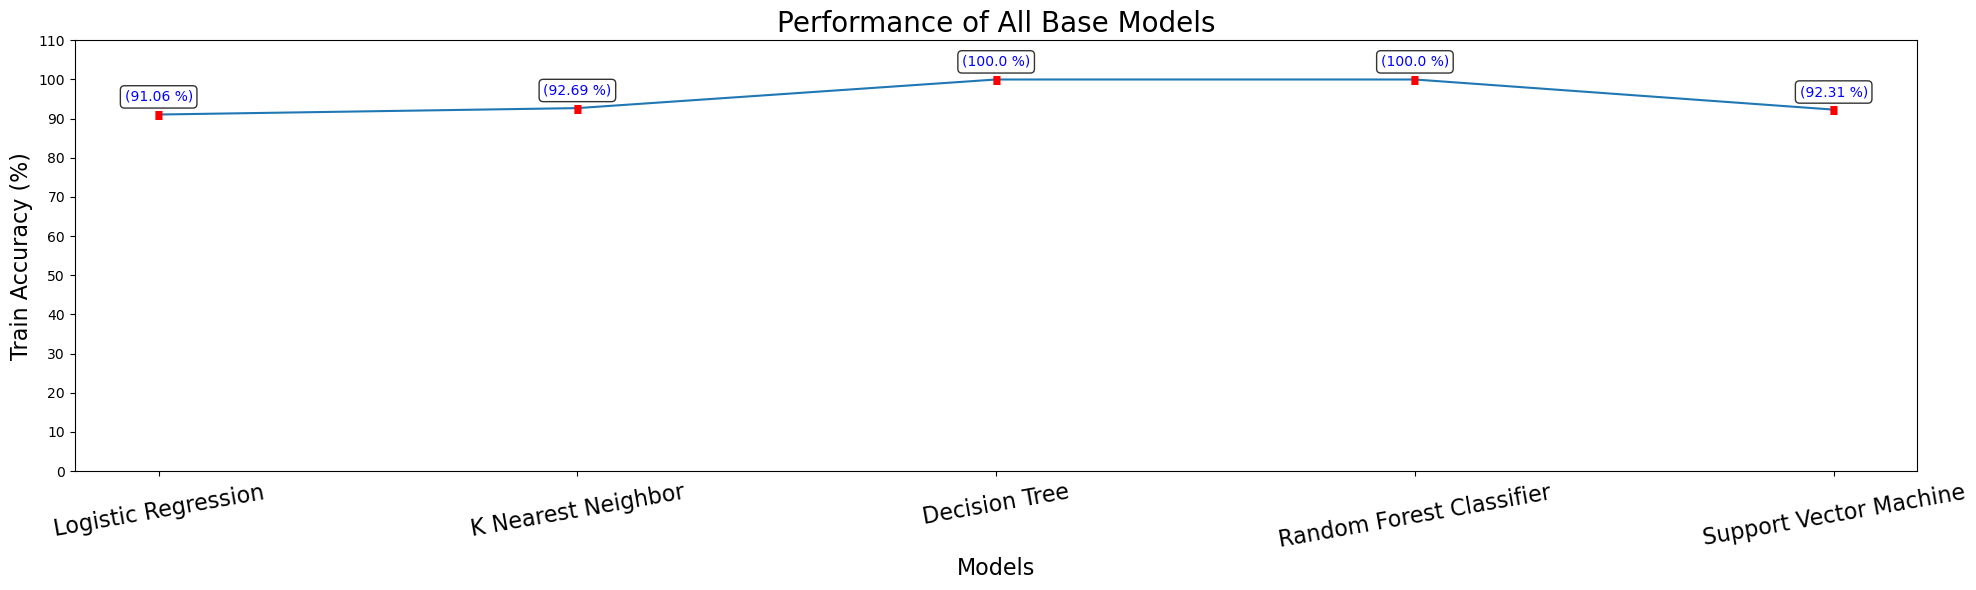

In [42]:
# Plot the performance of all the model used for prediction
x_trn= list(range(len(model_train_accuracy)))
y=list(range(0,111,10))

props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.figure(figsize=(20,6))
plt.plot(model_train_accuracy)
plt.yticks(y)
plt.xticks(fontsize=16)
plt.xticks(rotation = (10))
plt.xlabel("Models",fontsize=16)
plt.ylabel("Train Accuracy (%)",fontsize=16)
plt.title("Performance of All Base Models",fontsize=20)
for m,n in zip(x_trn,y):
    n = model_train_accuracy[m]
    val = "(" + str(round(model_train_accuracy[m],2)) + " %)"
    plt.text(m, n+4.5, val,horizontalalignment='center',verticalalignment='center',color='blue',bbox=props)
    plt.text(m, n+3.5, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)
plt.tight_layout()
plt.show()

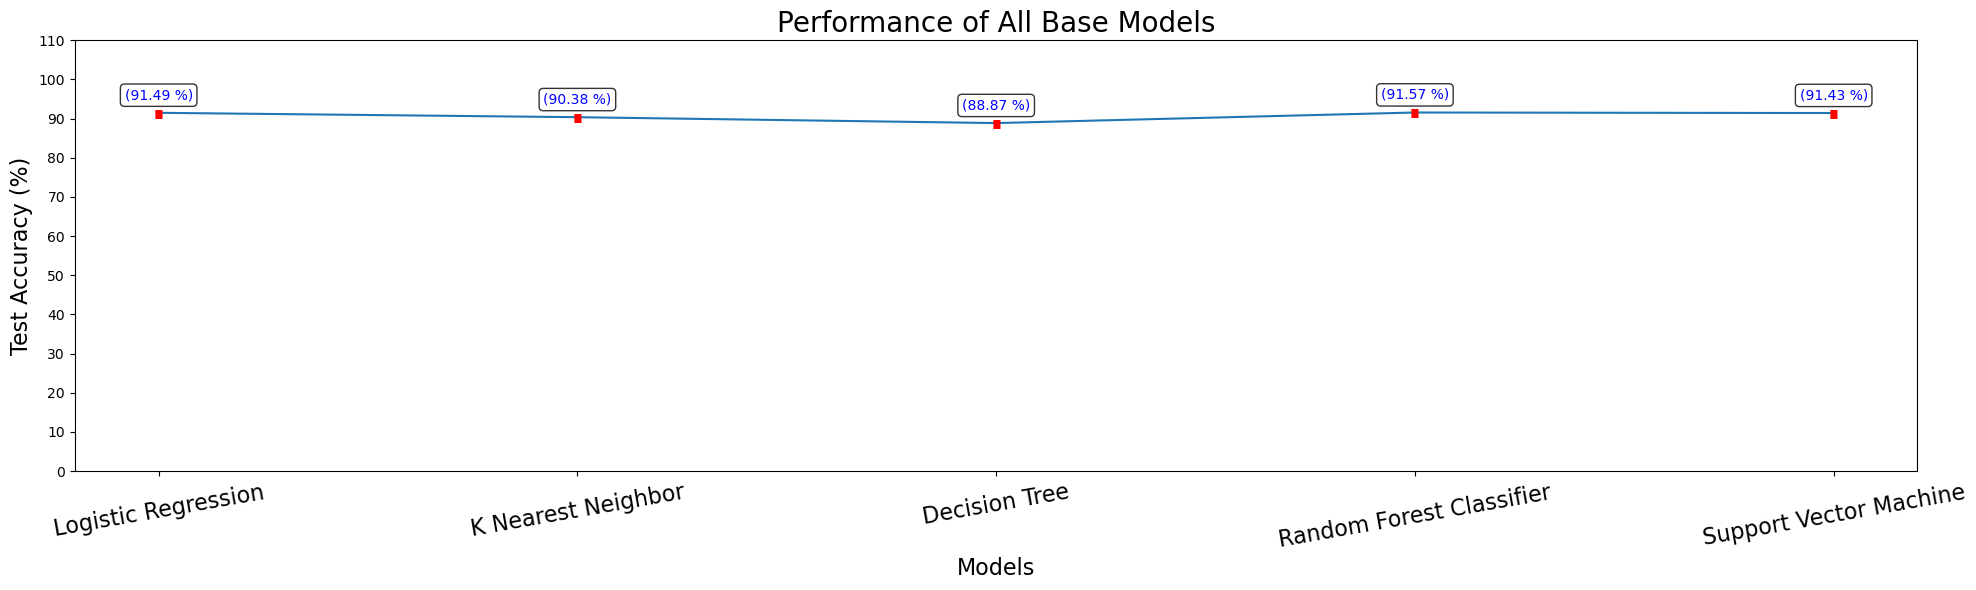

In [43]:
# Plot the performance of all the model used for prediction
x_tst= list(range(len(model_test_accuracy)))
y=list(range(0,111,10))

props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.figure(figsize=(20,6))
plt.plot(model_test_accuracy)
plt.yticks(y)
plt.xticks(fontsize=16)
plt.xticks(rotation = (10))
plt.xlabel("Models",fontsize=16)
plt.ylabel("Test Accuracy (%)",fontsize=16)
plt.title("Performance of All Base Models",fontsize=20)
for i,j in zip(x_tst,y):
    j = model_test_accuracy[i]
    val = "(" + str(round(model_test_accuracy[i],2)) + " %)"
    plt.text(i, j+4.5, val,horizontalalignment='center',verticalalignment='center',color='blue',bbox=props)
    plt.text(i, j+3.5, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)
plt.tight_layout()
plt.show()

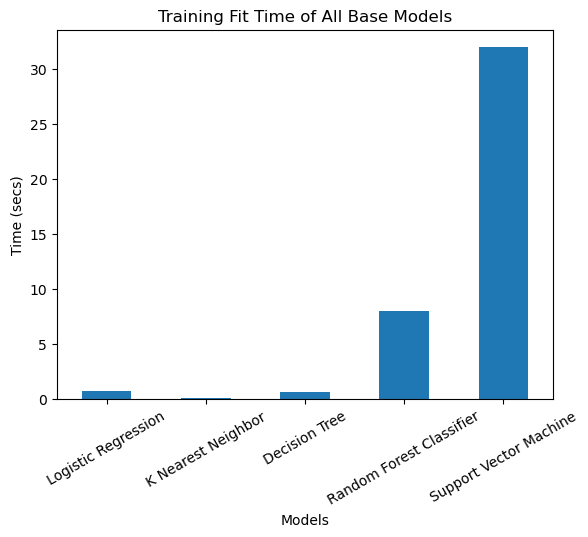

In [44]:
# Visualize the training time
model_fit_time.plot.bar()
plt.xticks(rotation = (30))
plt.xlabel("Models")
plt.ylabel("Time (secs)")
plt.title("Training Fit Time of All Base Models")
plt.show()

**Observations**

- KNN was the fastest and SVM slowest among all, from training fit time perspective. 
- All base models had 90%+ training accuracy but test accuracy dropped in all cases except Logistic Regression.
- Decision Tree had the perfect 100% training accuracy with big drop in Test accuracy, which shows that the model learned the entire training data and hence overfitted.
- Based on the above numbers, KNN and Logistic Regression looks like good base models.

### Step 9: Improving the Models

Now that we have some basic models on the board, we want to try to improve these.  There are multiple ways to improve the models, like:

- More feature engineering and exploration.  For example, should we keep the marital feature?
- Hyperparameter tuning and grid search. All of our models have additional hyperparameters to tune and explore. For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- We can adjust the performance metric.

In [45]:
# Define a results list and dataframe to store the final results
final_results_df = pd.DataFrame(index=['Train Accuracy (%)', 'Test Accuracy (%)', 'Precision', 'Recall', 
                                       'Train Time', 'Train Score', 'Test Score', 'ROC AUC Score'])

In [46]:
# Define a function and calculate scores and store them in a dataframe
def save_final_results(modelName, gridSearch):
    results_data = []
    print(f'Results for {modelName}:')
    # Calculate Accuracy, Precision, Recall scores
    test_preds = gridSearch.predict(X_test)
    train_preds = gridSearch.predict(X_train)
    trn_accuracy = accuracy_score(y_train, train_preds)
    tst_accuracy = accuracy_score(y_test, test_preds)
    tst_precision = precision_score(y_test, test_preds)
    tst_recall = recall_score(y_test, test_preds)
    print(f'    Train Accuracy   : {trn_accuracy: .2f}')
    print(f'    Test Accuracy    : {tst_accuracy: .2f}')
    print(f'    Test Precision   : {tst_precision: .2f}')
    print(f'    Test Recall      : {tst_recall: .2f}')
    
    # Store the search results in dataframe
    grid_result = pd.DataFrame(gridSearch.cv_results_)
    grid_result.head()
    
    # Get the Training, Test scores and Fit time
    trn_score = grid_result['mean_train_score'].mean()
    tst_score = grid_result['mean_test_score'].mean()
    fit_time = grid_result['mean_fit_time'].mean()
    print(f'    Training Score   : {trn_score: .8f}')
    print(f'    Test Score       : {tst_score: .8f}')
    print(f'    Training Fit Time: {fit_time: .8f}')
    
    # Calculate ROC AUC Score
    roc_auc_scr = roc_auc_score(y_true=y_test, y_score=test_preds)
    print(f'    ROC AUC Score    : {roc_auc_scr: .8f}')
    
    RocCurveDisplay.from_predictions(y_true=y_test, y_pred=test_preds, name="ROC Curve")
    
    # Store the results
    results_data.append(round(trn_accuracy*100,2))
    results_data.append(round(tst_accuracy*100,2))
    results_data.append(tst_precision)
    results_data.append(tst_recall)
    results_data.append(fit_time)
    results_data.append(trn_score)
    results_data.append(tst_score)
    results_data.append(roc_auc_scr)

    return results_data

#### Logistic Regression

In [47]:
# LogisticRegression
lgr_pipe = Pipeline([('transformer', transformer), ('lgr', LogisticRegression(solver='liblinear', max_iter=1000))])

lgr_params = [{'lgr__penalty':['l1', 'l2']}, 
              {'lgr__C':[0.001, 0.01, 0.1, 1, 10, 100]}]
lgr_grid = GridSearchCV(estimator = lgr_pipe, param_grid = lgr_params, return_train_score=True)
lgr_grid_start = time.time()
lgr_grid.fit(X_train, y_train)
lgr_grid_stop = time.time()
print(f'Grid Search Time : {(lgr_grid_stop - lgr_grid_start): .8f}s')

Grid Search Time :  35.94098663s


**Score the Model**

In [48]:
# Display the best params
lgr_grid.best_params_

{'lgr__C': 10}

Results for Logistic Regression:
    Train Accuracy   :  0.91
    Test Accuracy    :  0.92
    Test Precision   :  0.70
    Test Recall      :  0.43
    Training Score   :  0.90992623
    Test Score       :  0.90897832
    Training Fit Time:  0.76612117
    ROC AUC Score    :  0.70525714


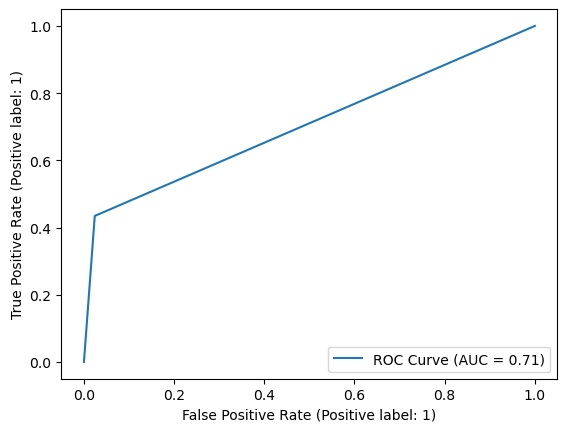

In [49]:
# Store the results
model_name = 'Logistic Regression'
final_results_df[model_name] = save_final_results(model_name, lgr_grid)

#### K Nearest Neighbor

In [50]:
# K Nearest Neighbor
# Use RandomizedSearchCV to find the hyperparameters best values
knn_pipe = Pipeline([('transformer', transformer), ('knn', KNeighborsClassifier())])
knn_params = {'knn__n_neighbors': range(1, 102, 2)}
knn_grid = RandomizedSearchCV(estimator=knn_pipe, param_distributions=knn_params, return_train_score=True)
knn_grid_start = time.time()
knn_grid.fit(X_train, y_train)
knn_grid_stop = time.time()
print(f'Grid Search Time : {(knn_grid_stop - knn_grid_start): .8f}s')

Grid Search Time :  146.39253736s


In [51]:
# Display the best params
knn_grid.best_params_

{'knn__n_neighbors': 31}

Results for K Nearest Neighbor:
    Train Accuracy   :  0.91
    Test Accuracy    :  0.91
    Test Precision   :  0.70
    Test Recall      :  0.33
    Training Score   :  0.91697825
    Test Score       :  0.90149236
    Training Fit Time:  0.11113273
    ROC AUC Score    :  0.65810271


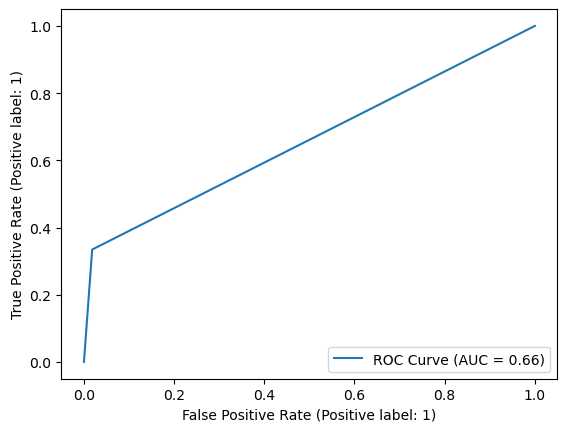

In [52]:
# Store the results
model_name = 'K Nearest Neighbor'
final_results_df[model_name] = save_final_results(model_name, knn_grid)

#### Decision Tree Classifier

In [53]:
# Decision Tree Classifier
# Use RandomizedSearchCV to find the hyperparameters best values
dtr_pipe = Pipeline([('transformer', transformer), ('dtr', DecisionTreeClassifier())])
dtr_params = {'dtr__max_depth': range(1, 20, 2),
              'dtr__min_samples_split': [2,3,4,5],
              'dtr__criterion': ['gini','entropy'],
              'dtr__min_samples_leaf': [1,2,3]
         }
dtr_grid = RandomizedSearchCV(estimator=dtr_pipe, param_distributions=dtr_params, return_train_score=True)
dtr_grid_start = time.time()
dtr_grid.fit(X_train, y_train)
dtr_grid_stop = time.time()
print(f'Grid Search Time : {(dtr_grid_stop - dtr_grid_start): .8f}s')

Grid Search Time :  23.48303771s


In [54]:
# Display the best params
dtr_grid.best_params_

{'dtr__min_samples_split': 2,
 'dtr__min_samples_leaf': 3,
 'dtr__max_depth': 9,
 'dtr__criterion': 'gini'}

Results for Decision Tree:
    Train Accuracy   :  0.93
    Test Accuracy    :  0.92
    Test Precision   :  0.65
    Test Recall      :  0.57
    Training Score   :  0.93976805
    Test Score       :  0.89653617
    Training Fit Time:  0.33168131
    ROC AUC Score    :  0.76397529


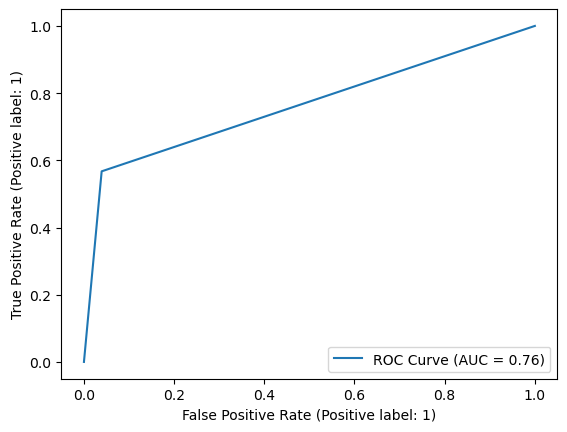

In [55]:
# Store the results
model_name = 'Decision Tree'
final_results_df[model_name] = save_final_results(model_name, dtr_grid)

#### Random Forest Classifier

In [56]:
# Random Forest Classifier
# Use RandomizedSearchCV to find the hyperparameters best values
rfc_pipe = Pipeline([('transformer', transformer), ('rfc', RandomForestClassifier())])
rfc_params = {'rfc__n_estimators': [25, 50, 100],
              'rfc__max_features': ['sqrt', None], 
              'rfc__max_depth': range(1, 20, 2),
              'rfc__max_leaf_nodes': [3, 6, 9]
         }
rfc_grid = RandomizedSearchCV(estimator=rfc_pipe, param_distributions=rfc_params, return_train_score=True)
rfc_grid_start = time.time()
rfc_grid.fit(X_train, y_train)
rfc_grid_stop = time.time()
print(f'Grid Search Time : {(rfc_grid_stop - rfc_grid_start): .8f}s')

Grid Search Time :  124.60547876s


In [57]:
# Display the best params
rfc_grid.best_params_

{'rfc__n_estimators': 50,
 'rfc__max_leaf_nodes': 9,
 'rfc__max_features': None,
 'rfc__max_depth': 17}

Results for Random Forest Classifier:
    Train Accuracy   :  0.91
    Test Accuracy    :  0.91
    Test Precision   :  0.65
    Test Recall      :  0.51
    Training Score   :  0.90050096
    Test Score       :  0.89999999
    Training Fit Time:  2.03576397
    ROC AUC Score    :  0.73653226


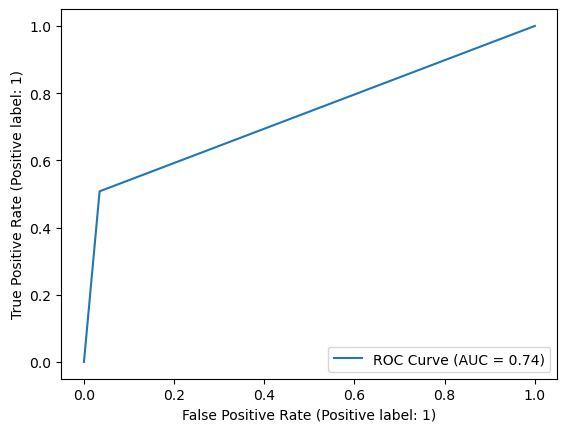

In [58]:
# Store the results
model_name = 'Random Forest Classifier'
final_results_df[model_name] = save_final_results(model_name, rfc_grid)

#### Support Vector Machine

In [59]:
#Support Vector Machine
# Intial GridSearch was tried with svc__kernel': ['rbf', 'poly', 'linear'] and svc__gamma': [0.1, 1.0, 10.0, 100.0]
# It took whopping 21 hours to find the best params as kernel --> rbf and gamma --> 0.1
# Now only tuning with the best params to save the time
svc_pipe = Pipeline([('transformer', transformer), ('svc', SVC())])
svc_params = {'svc__kernel': ['rbf'],
              'svc__gamma': [0.1],}
svc_grid = GridSearchCV(estimator = svc_pipe, param_grid = svc_params, return_train_score=True)
svc_grid_start = time.time()
svc_grid.fit(X_train, y_train)
svc_grid_stop = time.time()
print(f'Grid Search Time : {(svc_grid_stop - svc_grid_start): .8f}s')

Grid Search Time :  387.90034676s


In [60]:
# Display the best params
svc_grid.best_params_

{'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

Results for Support Vector Machine:
    Train Accuracy   :  0.94
    Test Accuracy    :  0.91
    Test Precision   :  0.68
    Test Recall      :  0.42
    Training Score   :  0.93737658
    Test Score       :  0.90838752
    Training Fit Time:  22.90830560
    ROC AUC Score    :  0.69760122


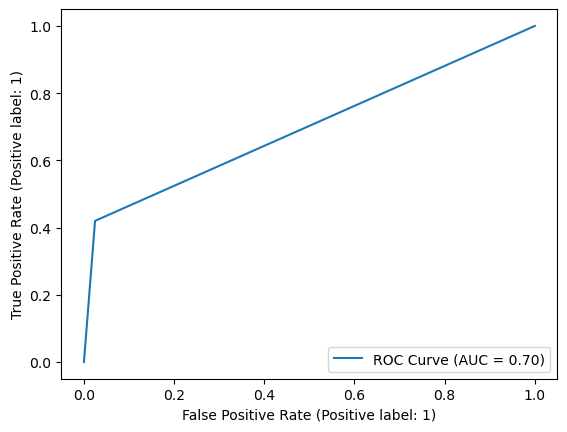

In [61]:
# Store the results
model_name = 'Support Vector Machine'
final_results_df[model_name] = save_final_results(model_name, svc_grid)

In [62]:
# Display the final results
final_results_df

,Logistic Regression,K Nearest Neighbor,Decision Tree,Random Forest Classifier,Support Vector Machine
Train Accuracy (%),91.050000,90.900000,93.150000,91.260000,93.630000
Test Accuracy (%),91.500000,90.880000,91.640000,91.380000,91.280000
Precision,0.697095,0.699099,0.647001,0.650110,0.683989
Recall,0.434483,0.334483,0.567241,0.507759,0.419828
Train Time,0.766121,0.111133,0.331681,2.035764,22.908306
Train Score,0.909926,0.916978,0.939768,0.900501,0.937377
Test Score,0.908978,0.901492,0.896536,0.900000,0.908388
ROC AUC Score,0.705257,0.658103,0.763975,0.736532,0.697601


**Observations**

- Tree based models had the best ROC Scores with Decision Tree Classifier at the top with 0.74 and Random Forest Classifier next at 0.72.
- All tuned models had the Training and Test accuracy of at least 90%.
- SVM took the longest to train and fit the model.
- Overall Decision Tree Classifier model performed the best out of all tuned models.

**Compare the ROC Score of all the tuned models** 

In [63]:
# Visualize all the tuned models performances
# Change the datatype of final_results_df columns to float
for i in final_results_df.columns:
    final_results_df[i] = final_results_df[i].astype(float)
model_roc_score = final_results_df.loc['ROC AUC Score']

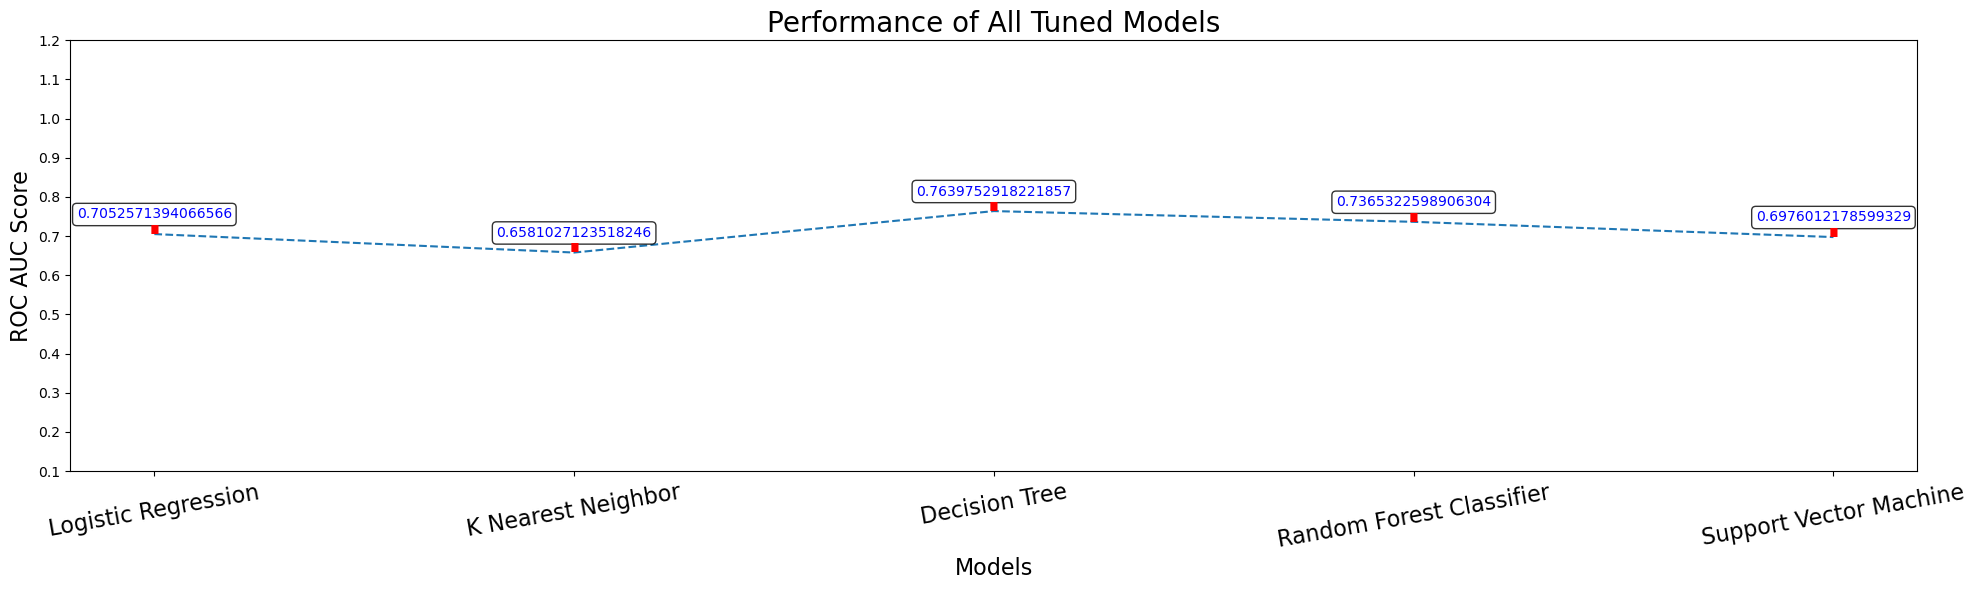

In [64]:
# Plot the performance of all the model used for prediction
x= list(range(len(model_roc_score)))
y=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0, 1.1,1.2]

props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.figure(figsize=(20,6))
plt.plot(model_roc_score, linestyle='--')
plt.yticks(y)
plt.xticks(fontsize=16)
plt.xticks(rotation = (10))
plt.xlabel("Models",fontsize=16)
plt.ylabel("ROC AUC Score",fontsize=16)
plt.title("Performance of All Tuned Models",fontsize=20)
for i,j in zip(x,y):
    j = model_roc_score[i]
    val = model_roc_score[i]
    plt.text(i, j+.05, val,horizontalalignment='center',verticalalignment='center',color='blue',bbox=props)
    plt.text(i, j+.05, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)
plt.tight_layout()
plt.show()

**Feature Importantance for Decision Tree Classifier**

In [65]:
# Create features importance dataframe, sort them by order of higher importance
feature_names = []
feature_importances = []
for name, importance in zip(dtr_pipe[:-1].get_feature_names_out(), dtr_grid.best_estimator_.named_steps['dtr'].feature_importances_):
    name = name.replace('remainder__', '')
    name = name.replace('onehotencoder__', '')
    feature_names.append(name)
    feature_importances.append(round(importance * 100, 2))

features_dtr = pd.DataFrame({'Features':feature_names, 'Importance (%)':feature_importances})
features_dtr[features_dtr['Importance (%)'] > 0].sort_values(by='Importance (%)', ascending=False)

,Features,Importance (%)
44,duration,45.73
53,nr.employed,27.99
52,euribor3m,5.08
46,pdays,3.90
40,age,3.78
51,cons.conf.idx,3.26
33,month_oct,0.99
47,previous,0.89
50,cons.price.idx,0.86
45,campaign,0.82


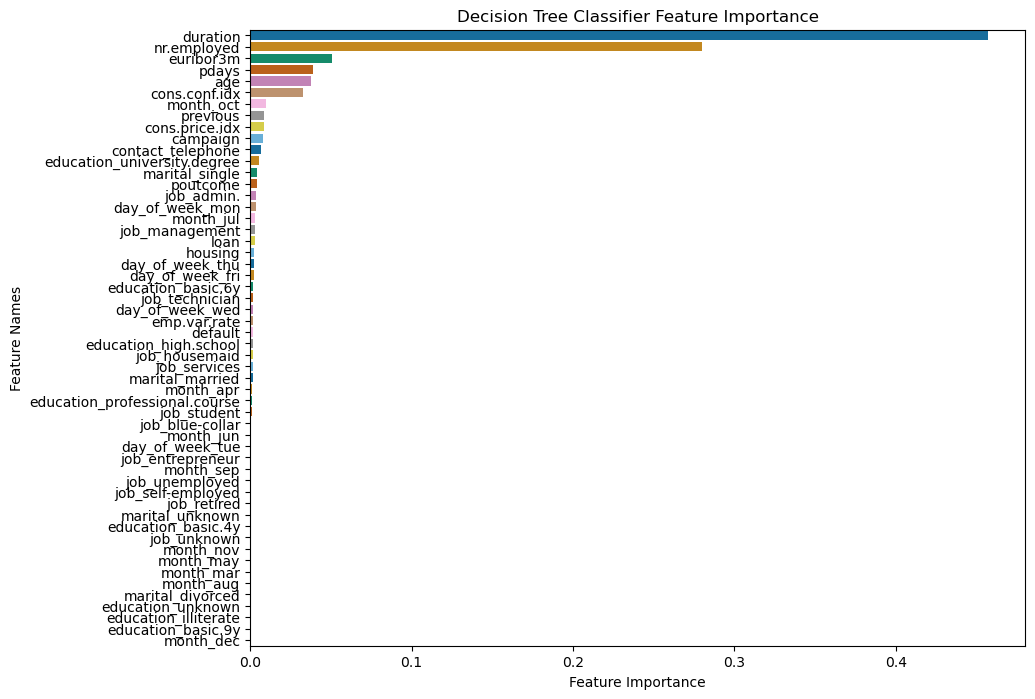

In [66]:
# Plot the Important Features for visual interpretation
def plot_feature_importance(importance,names,model_type):
    f_names = []
    for name in names:
        name = name.replace('remainder__', '')
        name = name.replace('onehotencoder__', '')
        f_names.append(name)
        
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(f_names)

    # Create a DataFrame using a Dictionary of features names and their importance factors
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order of the importance of the features
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    # Define size of the plot
    plt.figure(figsize=(10,8))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], 
                palette = 'colorblind')
    # Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')


plot_feature_importance(dtr_grid.best_estimator_.named_steps['dtr'].feature_importances_,
                        dtr_pipe[:-1].get_feature_names_out(),'Decision Tree Classifier')

**Feature Importantance for Random Forest Classifier**

In [67]:
# Create features importance dataframe, sort them by order of higher importance
feature_names = []
feature_importances = []
for name, importance in zip(rfc_pipe[:-1].get_feature_names_out(), rfc_grid.best_estimator_.named_steps['rfc'].feature_importances_):
    name = name.replace('remainder__', '')
    name = name.replace('onehotencoder__', '')
    feature_names.append(name)
    feature_importances.append(round(importance * 100, 2))

features = pd.DataFrame({'Features':feature_names, 'Importance (%)':feature_importances})
features[features['Importance (%)'] > 0].sort_values(by='Importance (%)', ascending=False)

,Features,Importance (%)
44,duration,52.26
53,nr.employed,38.42
51,cons.conf.idx,3.21
46,pdays,2.96
52,euribor3m,1.00
48,poutcome,0.84
33,month_oct,0.75
50,cons.price.idx,0.26
30,month_mar,0.20
25,month_apr,0.07


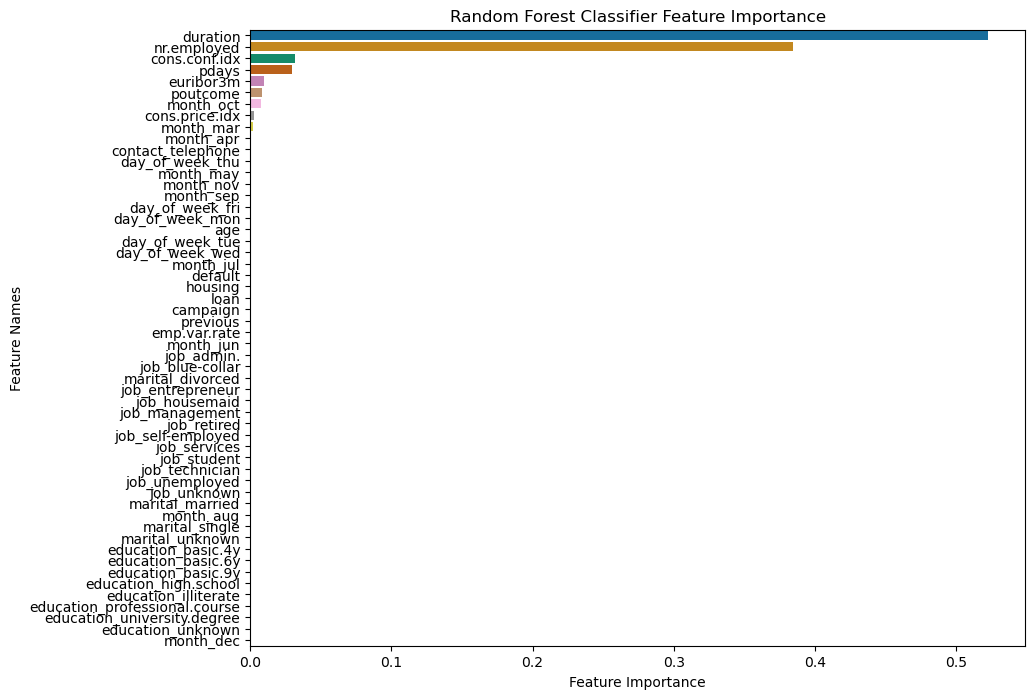

In [68]:
# Plot the Important Features for visual interpretation
def plot_feature_importance(importance,names,model_type):
    f_names = []
    for name in names:
        name = name.replace('remainder__', '')
        name = name.replace('onehotencoder__', '')
        f_names.append(name)
        
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(f_names)

    # Create a DataFrame using a Dictionary of features names and their importance factors
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order of the importance of the features
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    # Define size of the plot
    plt.figure(figsize=(10,8))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], 
                palette = 'colorblind')
    # Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')


plot_feature_importance(rfc_grid.best_estimator_.named_steps['rfc'].feature_importances_,
                        rfc_pipe[:-1].get_feature_names_out(),'Random Forest Classifier')

### Recommendations

- Call duration ('duration') played the most important role with ~52% which means if customers are engaged longer during the marketing calls then it increases the chance of subscribing to term deposit products.
- Number of employees ('nr.employed') was the next important feature which means customer trust the larger banks more than the smaller banks for the long term deposit products.
- Customer's committment to term deposit product was also found to be dependent on social and economic contextual features like Consumer Price Index (cons.conf.idx), Europe's Short Term Libor Rate ('euribor3m') etc.
- Customer are more likely to subscribe during month of October compared to other months.
- If customers had agreed to subscribe to a term deposit in past then they more likely to subscribe again during next marketing campaign. This is evident due to Previous Outcome ('poutcome') feature importance.

### Conclusion on Comparing Classifiers

- Tree based models had the best ROC Scores with Decision Tree Classifier at the top with 0.74 and Random Forest Classifier next at 0.72.
- All tuned models had the Training and Test accuracy of at least 90%.
- SVM took the longest to train and fit the model.
- Overall Decision Tree Classifier model performed the best out of all tuned models.

**Next Steps**

- Due to personal computer constraints, hyperparameter tuning for all models were limited to return in reasonable amount of time so there's a possibility that models can be further tuned with better parameters.
- Data transformation and cleaning can be revisited to improve training and test data quality.